<a href="https://colab.research.google.com/github/kyrillosishak/re-SkinCancer/blob/main/Notebooks/02_correctingDataLeakage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mitigating Data Leakage in Skin Cancer Classification with Transfer Learning

`Skin Cancer Classification with Transfer Learning` paper that we are discussing uses HAM_10000 dataset.

The HAM_10000 dataset is a widely used dataset for dermatological image classification, containing thousands of images of pigmented lesions. While it has been a valuable resource for training machine learning models, recent studies have highlighted significant issues with data leakage due to duplicate images within the dataset. This data leakage can lead to overly optimistic performance estimates and undermine the validity of research findings \[2\].

In this notebook, we tackle the data leakage problem in the HAM_10000 dataset by addressing the duplicates within the dataset. Notably, insights from the survey paper “Leakage and the Reproducibility Crisis in ML-based Science” highlighted the issue of data leakage and its detrimental effects on reproducibility in machine learning. This survey also references the study “Investigating the Quality of DermaMNIST and Fitzpatrick17k Dermatological Image Datasets,” which provided evidence of duplicate images in dermatological datasets, including `HAM_10000`\[1\].

Our approach involves two main notebooks: the first reproduces the original paper, and the second focuses on identifying and addressing data leakage in the HAM_10000 dataset. By showing image similarity and identifying duplicates, we will clean the validation dataset and subsequently evaluate the impact on model accuracy and confusion metrics.

------------------------------------------------------------------------

**🔍 In this notebook, we will:**

1.  Identify Duplicates in `HAM_10000`4
2.  Clean the Validation Dataset.
3.  Evaluate Model Performance on new clean validation data.
4.  Discuss Implications.

## **1. Identify Duplicates in HAM_10000**

**`HAM_10000` have severe flaw :**

> A caveat of HAM10000, despite its rather large size, is that it contains multiple images of the same lesion captured either from different viewing angles or at different magnification levels

> the number of lesions with unique lesion IDs (HAM_xxx) is smaller than the number of images with unique image IDs (ISIC_xxx).

> observe that the 10,015 images are in fact derived from only 7,470 unique lesions, and 1,956 of these lesion IDs (∼26.18%) contains 2 or more images: 1,423 lesions have 2 images, 490 lesions have 3 images, 34 lesions have 4 images, 5 lesions have 5 images, and 6 lesions have 4 images each.

<img src = "https://raw.githubusercontent.com/kyrillosishak/re-SkinCancer/main/assets/Near-duplicate_HAM10000.png" height = 150> <img src = "https://raw.githubusercontent.com/kyrillosishak/re-SkinCancer/main/assets/Near-duplicate2_HAM10000.png" height = 150>

*This images from \[2\].*

This results in near-duplicates within the dataset, which can compromise the integrity of any machine learning model trained on it. The presence of near-duplicate images can lead to data leakage, where the model learns to recognize specific lesions rather than generalizing to new, unseen lesions.

*The duplicates were identified using a tool called [FastDup](https://github.com/visual-layer/fastdup) in the repository.*

In [1]:
# Download the dataset to dir data
!curl -L -O -J -H "X-Dataverse-key:$API_TOKEN" https://dataverse.harvard.edu/api/access/dataset/:persistentId/?persistentId=doi:10.7910/DVN/DBW86T
!unzip -q dataverse_files.zip
!mkdir data
%cd data
!unzip -q ../HAM10000_images_part_1.zip
!unzip -q ../HAM10000_images_part_2.zip
%cd ..

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3051M    0 3051M    0     0  17.7M      0 --:--:--  0:02:52 --:--:-- 19.1M
/content/data
/content


In [4]:
import pandas as pd
# Read the CSV file containing metadata for the HAM10000 dataset
meta_data = pd.read_csv('HAM10000_metadata')

# Group the image filenames by their class labels ('dx') and convert the groups to a dictionary
# The dictionary keys are class labels and the values are lists of image filenames belonging to each class
class_files = meta_data.groupby('dx')['image_id'].apply(list).to_dict()

# Create a mapping from class names to integer indices
# This is useful for converting class labels to numeric format for machine learning tasks
label_map = {class_name: idx for idx, class_name in enumerate(class_files.keys())}

# Create a list of class names
class_names = [class_name for class_name in class_files.keys()]

print("Class names: ",class_names)
print("Label map: ",label_map)

Class names:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Label map:  {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## **2. Clean the data**

In `HAM_10000` there is problem in the data :

It contains multiple images of the same lesion captured either from different viewing angles or at different magnification levels

-   To fix this issue we will put the images with the same lesion_id in the train set and the rest of them will be in the validation set


In [5]:
import os
import copy
import math
import torch
import random
import PIL.Image
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Loading dataset

In [6]:
class SkinLesionDataset(Dataset):
    """
    A custom dataset class for loading and transforming images of skin lesions along with their labels.

    Args:
        image_list (list of str): List of image filenames.
        labels (list of int): List of labels corresponding to each image.
        transform (callable, optional): Optional transform to be applied on an image sample.
    """
    def __init__(self, image_list, labels, transform=None):
        self.image_list = image_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = self.image_list[idx]
        img_path = "./data/"+img_path+".jpg"
        image = PIL.Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [11]:
def process_train_val_loader(df, target_size, train_transform, val_transform):
    """
    Processes and prepares the training and validation data loaders.

    Args:
        target_size (int): The desired number of training images after augmentation.
        train_transform (callable): Transformations to be applied to training images.
        val_transform (callable): Transformations to be applied to validation images.

    Returns:
        tuple: A tuple containing the training dataset, validation dataset, training data loader, and validation data loader.
    """
    # Load metadata and initialize lists
    class_files = df.groupby('dx')['image_id'].apply(list).to_dict()
    label_map = {class_name: idx for idx, class_name in enumerate(class_files.keys())}

    train_images, train_labels, val_images, val_labels = [], [], [], []

    # Process each class to remove confusing images and handle similar ones
    for class_name, image_list in class_files.items():

        labels = [label_map[class_name]] * len(image_list)
        train_dataset, val_dataset = augment_and_split_data(df, image_list, labels, train_transform, val_transform, target_size)

        train_images.extend(train_dataset.image_list)
        train_labels.extend(train_dataset.labels)
        val_images.extend(val_dataset.image_list)
        val_labels.extend(val_dataset.labels)

    train_dataset = SkinLesionDataset(train_images, train_labels, transform=train_transform)
    val_dataset = SkinLesionDataset(val_images, val_labels, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

    return train_dataset, val_dataset, train_loader, val_loader


def augment_and_split_data(df, image_list, label_list, train_transform, val_transform, target_size=300):
    """
    Augments and splits a dataset of images and labels into training and validation sets.

    Args:
        df (pd.DataFrame): DataFrame containing 'image_id' and 'lesion_id' columns.
        image_list (list of str): List of image filenames.
        label_list (list of int): List of labels corresponding to each image.
        train_transform (callable): Transformations to be applied to training images.
        val_transform (callable): Transformations to be applied to validation images.
        target_size (int, optional): Desired number of training images after augmentation. Default is 300.

    Returns:
        tuple: A tuple containing the training dataset and validation dataset.
    """
    combined = list(zip(image_list, label_list))
    random.shuffle(combined)
    image_list[:], label_list[:] = zip(*combined)

    lesion_dict = df.set_index('image_id')['lesion_id'].to_dict()
    lesion_groups = {lesion_id: [] for lesion_id in lesion_dict.values()}

    for img, lbl in combined:
        lesion_id = lesion_dict[img]
        lesion_groups[lesion_id].append((img, lbl))

    train_images_labels, val_images_labels = [], []

    for lesion_id, imgs_labels in lesion_groups.items():
        if len(val_images_labels) + len(imgs_labels) <= 0.2 * len(image_list) :
            val_images_labels.extend(imgs_labels)
        else:
            train_images_labels.extend(imgs_labels)

    train_images, train_labels = zip(*train_images_labels)
    val_images, val_labels = zip(*val_images_labels)

    if len(train_images) > 360:
        train_images = train_images[:360]
        train_labels = train_labels[:360]
    if len(val_images) > 90:
        val_images = val_images[:90]
        val_labels = val_labels[:90]

    augmented_images, augmented_labels = [], []
    while len(augmented_images) < target_size:
        for img, label in zip(train_images, train_labels):
            augmented_images.append(img)
            augmented_labels.append(label)
            if len(augmented_images) >= target_size:
                break

    train_dataset = SkinLesionDataset(augmented_images, augmented_labels, transform=train_transform)
    val_dataset = SkinLesionDataset(val_images, val_labels, transform=val_transform)

    return train_dataset, val_dataset


In [8]:
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(
        degrees=30,
        translate=(0.1, 0.1),
        scale=None,
        shear=10
    ),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

In [9]:
meta_data = pd.read_csv('HAM10000_metadata')

In [12]:
number = 1000
num_epochs = 100
patience = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset, val_dataset, train_loader, val_loader = process_train_val_loader(meta_data, number, train_transform, val_transform)
print("Size of trainset : " + str(len(train_dataset.image_list)))
print("Size of validationset : " + str(len(val_dataset.image_list)))

Size of trainset : 7000
Size of validationset : 476


After cleaning the data we should use the code in [Reproducing the original paper notebook](Markdowns/01-reproducingSkinCancer.md) to train the model on the clean data.

## **3. Evaluate Model Performance on new clean validation data**

1.  Downloading the model trained on the cleaned data and the model trained on duplicated data.
2.  Downloading the datasets that is used in every model.
3.  Evaluate each model

In [15]:
!wget -q https://huggingface.co/KyrillosIshak/Re-SkinCancer/resolve/main/Experiments/exp4/val_loader_clean_lesion_only.pt
!wget -q https://huggingface.co/KyrillosIshak/Re-SkinCancer/resolve/main/Experiments/exp2/val_loader.pt

In [17]:
val_loader_clean = torch.load('val_loader_clean_lesion_only.pt')
val_loader = torch.load('val_loader.pt')

In [18]:
!wget -q https://huggingface.co/KyrillosIshak/Re-SkinCancer/resolve/main/Experiments/exp4/1000_clean_lesion_only.pt
!wget -q https://huggingface.co/KyrillosIshak/Re-SkinCancer/resolve/main/Experiments/exp2/1000.pt

In [19]:
class ModifiedInceptionResNetV2(nn.Module):
    """ModifiedInceptionResNetV2 class for transfer learning with custom classifier.

      This class implements a modified version of the Inception ResNet V2 model for image classification tasks.
      It leverages transfer learning by freezing the pre-trained feature extraction layers from a
      provided Inception ResNet V2 model and adding a custom classifier on top.

      Args:
          original_model (torchvision.models.InceptionV3): A pre-trained Inception ResNet V2 model
              (typically loaded with `pretrained=True`).
          num_classes (int, optional): The number of output classes for the classification task.
              Defaults to 7.

      Attributes:
          features (nn.Sequential): A sequential container holding all layers from the original model
              except the final classifier (Softmax layer).
          classifier (nn.Sequential): A custom classifier consisting of:
              - nn.Flatten(): Flattens the input from the feature extractor.
              - nn.Linear(1536, 64): First fully-connected layer with 64 units and ReLU activation.
              - nn.Linear(64, num_classes): Second fully-connected layer with 'num_classes' units
                and Softmax activation for probability distribution of the classes.
    """
    def __init__(self, original_model, num_classes=7):
        super(ModifiedInceptionResNetV2, self).__init__()

        # Retain all layers except the final classifier(Softmax)
        self.features = nn.Sequential(*list(original_model.children())[:-1])

        # Custom classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # 1536 output from the last layer after removing the classifier
            nn.Linear(1536, 64),  # First fully connected layer
            nn.ReLU(),
            nn.Linear(64, num_classes),  # Second fully connected layer
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [20]:
!pip -q install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.1 MB/s eta 0:00:00


In [21]:
from timm import create_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model('inception_resnet_v2', pretrained=True,num_classes=7)
modified_model = ModifiedInceptionResNetV2(model, num_classes=7)

clean_model = copy.deepcopy(modified_model)
Dataleaked_model = copy.deepcopy(modified_model)

clean_model.load_state_dict(torch.load('1000_clean_lesion_only.pt')['model'])
Dataleaked_model.load_state_dict(torch.load('1000.pt')['model'])

clean_model.to(device)
Dataleaked_model.to(device)

clean_model.eval()
Dataleaked_model.eval()
print("Loaded model successfully.")

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

Loaded model successfully.


In [22]:
def get_predictions_and_labels(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

In [23]:
val_preds_duplicates, val_labels_duplicates = get_predictions_and_labels(Dataleaked_model, val_loader, device)
val_preds_clean, val_labels_clean = get_predictions_and_labels(clean_model, val_loader_clean, device)

In [24]:
accuracy_duplicates = np.mean(val_preds_duplicates == val_labels_duplicates)*100
accuracy_clean = np.mean(val_preds_clean == val_labels_clean)*100
print(f"Validation Accuracy of the duplicated set: {accuracy_duplicates:.4f}")
print(f"Validation Accuracy of the clean set: {accuracy_clean:.4f}")

Validation Accuracy of the duplicated set: 78.8703
Validation Accuracy of the clean set: 72.0588


In [25]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [26]:
# Compute confusion matrix
cm1 = confusion_matrix(val_labels_duplicates, val_preds_duplicates)
cm2 = confusion_matrix(val_labels_clean, val_preds_clean)

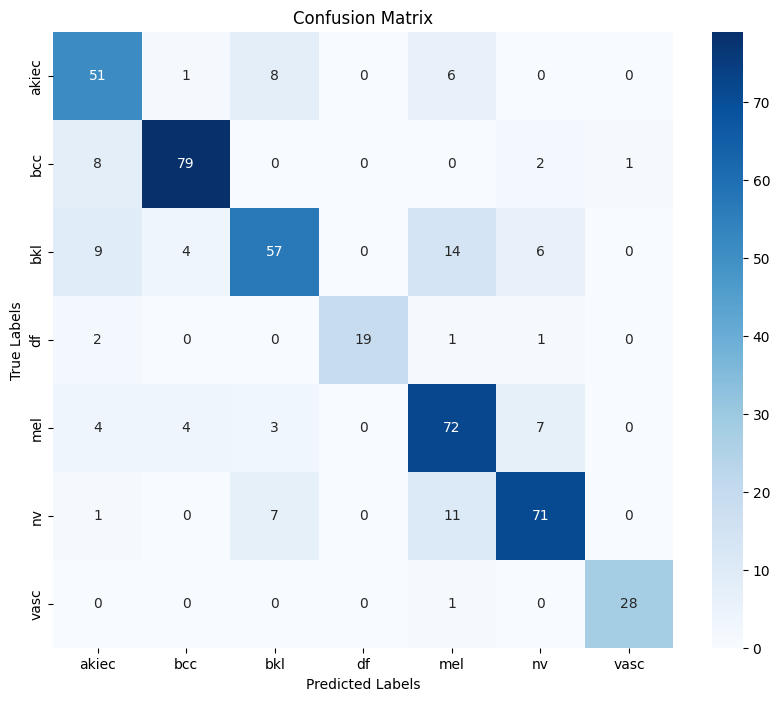

In [27]:
# Plot confusion matrix
plot_confusion_matrix(cm1, class_names)

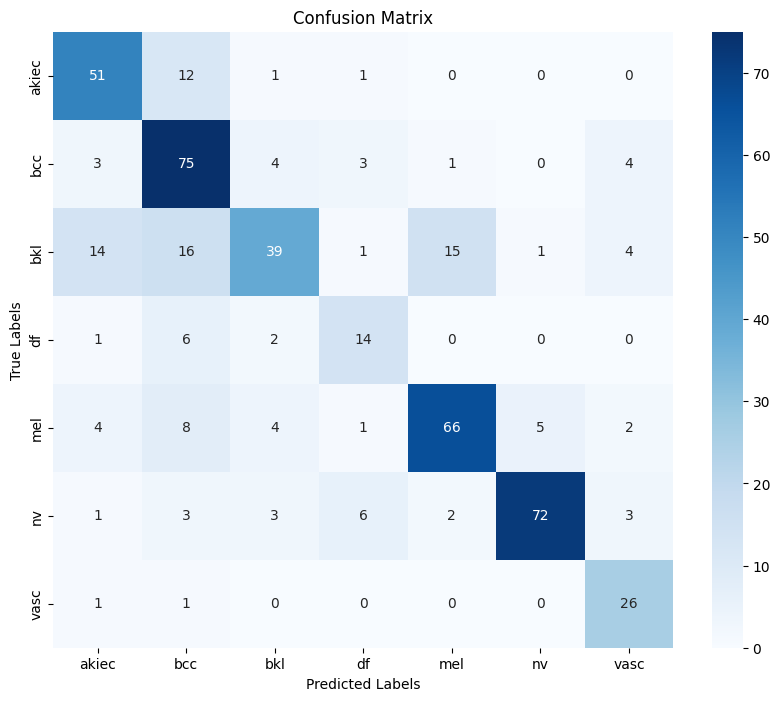

In [28]:
# Plot confusion matrix
plot_confusion_matrix(cm2, class_names)

As we see here, the model tested on images with near-duplicates in the training set achieves higher accuracy than the model tested on clean data, with a validation accuracy of 78.8703% compared to 72.0588%. This discrepancy highlights a significant issue : the presence of near-duplicate images in datasets can artificially inflate performance metrics, leading to misleading conclusions about a model’s efficacy. This has implications on the reproducibility and reliability of published research. Papers that report inflated performance metrics due to such data issues may set unrealistic benchmarks, making it difficult for subsequent researchers to replicate results or make fair comparisons. To ensure the integrity and credibility of machine learning research, it is crucial to rigorously check for and address near-duplicates and other forms of data leakage before publishing results.

## **Refrences**

1.  [Leakage and the Reproducibility Crisis in ML-based Science](https://arxiv.org/abs/2207.07048)

2.  [Investigating the Quality of DermaMNIST and Fitzpatrick17k Dermatological Image Dataset](https://arxiv.org/pdf/2401.14497)